In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.autograd import Variable
import gym
from torch.distributions import Categorical
import numpy as np
import matplotlib.pyplot as plt

### Policy

In [13]:
class Policy(nn.Module):
  def __init__(self, input_size, output_size):
    super(Policy, self).__init__()
    self.linear1 = nn.Linear(input_size, 256)
    self.linear2 = nn.Linear(256, 128)
    self.linear3 = nn.Linear(128, output_size)

  def forward(self, inputs):
    x = F.relu(self.linear1(inputs))
    x = F.relu(self.linear2(x))
    x = self.linear3(x)
    return F.softmax(x, dim=1)

### Baseline

In [14]:
class BaseLine(nn.Module):
    def __init__(self, input_size):
        super(BaseLine, self).__init__()
        self.linear1 = nn.Linear(input_size, 256)
        self.linear2 = nn.Linear(256, 128)
        self.linear3 = nn.Linear(128, 1)

    def forward(self, inputs):
        x = F.relu(self.linear1(inputs))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)

        return x

### Agent class

In [16]:
class MCREINFORCE:
  def __init__(self, env, seed = 0, baseline=False):
    self.num_inputs = env.observation_space.shape[0]
    self.num_actions = env.action_space.n
    self.policy = Policy(self.num_inputs, self.num_actions)
    #self.policy.to('cuda')
    torch.manual_seed(seed)
    self.optimizer = Adam(self.policy.parameters())
    self.policy.train()
    self.baseline = baseline
    if self.baseline:
      self.value_net = BaseLine( self.num_inputs)
      self.value_optimizer = Adam(self.value_net.parameters())

  def action_select(self, state):
    p = self.policy(Variable(torch.from_numpy(state).float().unsqueeze(0)))#.cuda())
    m = Categorical(p)
    action = m.sample()
    log_p = m.log_prob(action)
    return action.item(), log_p

  def calc_return_pg(self, log_ps, rewards, gamma,baseline_vals):
    policy_gradient = 0
    R = torch.zeros(1,1)
    if self.baseline:
      for i in reversed(range(len(rewards))):
        R = gamma*R + rewards[i]
        policy_gradient -= (log_ps[i]*(R-baseline_vals[i])).sum()#.cuda()).sum()
    else:
      for i in reversed(range(len(rewards))):
        R = gamma*R + rewards[i]
        policy_gradient -= (log_ps[i]*(R)).sum()#.cuda()).sum()
    policy_gradient = policy_gradient / len(rewards)
    return R, policy_gradient

  def update_policy(self, pg):
    policy_gradient = pg
    #print(policy_gradient)
    self.optimizer.zero_grad()
    policy_gradient.backward()
    self.optimizer.step()

  def update_baseline(self, rewards, states):
    states = torch.tensor(states).float()
    reward_tensor = torch.tensor(rewards).float()
    with torch.no_grad():
      td = reward_tensor + 0.99*self.value_net(states).squeeze(1)
    pred = self.value_net(states).squeeze(1)
    loss = F.mse_loss(pred, td)

    self.value_optimizer.zero_grad()
    loss.backward()
    self.value_optimizer.step()

### Plotting:

In [17]:
def final_plot(TT_type_1, TT_type_2):
    TT1_mean = np.mean(TT_type_1, axis = 0)
    TT1_std = np.std(TT_type_1, axis = 0)


    TT2_mean = np.mean(TT_type_2, axis = 0)
    TT2_std = np.std(TT_type_2, axis = 0)


    # Plotting
    plt.figure(figsize=(10, 6))

    # Plot Type-1 scores
    plt.plot(TT1_mean, label='MCR without baseline', color='blue')
    plt.fill_between(range(len(TT1_mean)),
                  TT1_mean - TT1_std,
                  TT1_mean + TT1_std,
                  alpha=0.3, color='blue')

    # Plot Type-2 scores
    plt.plot(TT2_mean, label='MCR with baseline', color='red')
    plt.fill_between(range(len(TT2_mean)),
                  TT2_mean - TT2_std,
                  TT2_mean + TT2_std,
                  alpha=0.3, color='red')

    # Plot labels and legend
    plt.title('MCR without baseline and MCR with baseline')
    plt.xlabel('Episodes')
    plt.ylabel('Average Score')
    plt.legend()

    # Show plot
    plt.show()

    return True

### Cartpole:

#### Without baseline

In [7]:
import sys
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

env = gym.make('CartPole-v1')
agent = MCREINFORCE(env)
gamma = 0.99
num_episodes= 1000
num_steps = 500
tot_rewards_cwob = []
num_epochs = 5
env.seed(0)

for epoch in range(num_epochs):
    rewards = []
    for episode in range(num_episodes):
        state = env.reset()
        log_ps = []
        episode_rewards = []
        states = []
        for t in range(num_steps):
            action, log_p = agent.action_select(state)
            next_state, reward, done, _ = env.step(action)
            log_ps.append(log_p)
            episode_rewards.append(reward)
            states.append(state)
            state = next_state

            if done:
                break
        
        baseline_vals = None
        if agent.baseline:
            agent.update_baseline(episode_rewards,states)

            with torch.no_grad():
                state_tensor = torch.tensor(states).float()
                baseline_vals = agent.value_net(state_tensor).squeeze().tolist()

        R, pg = agent.calc_return_pg(log_ps, episode_rewards, gamma, baseline_vals)
        agent.update_policy(pg)
        rewards.append(np.array(episode_rewards).sum())
    tot_rewards_cwob.append(rewards)

/home/user/miniconda3/envs/RL/lib/python3.12/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/user/miniconda3/envs/RL/lib/python3.12/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/user/miniconda3/envs/RL/lib/python3.12/site-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
/home/user/miniconda3/envs/RL/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning

#### With baseline

In [9]:
import sys
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

env = gym.make('CartPole-v1')
agent = MCREINFORCE(env, baseline=True)
gamma = 0.99
num_episodes= 1000
num_steps = 500
tot_rewards_cwb = []
num_epochs = 5
env.seed(0)

for epoch in range(num_epochs):
    rewards = []
    for episode in range(num_episodes):
        state = env.reset()
        log_ps = []
        episode_rewards = []
        states = []
        for t in range(num_steps):
            action, log_p = agent.action_select(state)
            next_state, reward, done, _= env.step(action)
            log_ps.append(log_p)
            episode_rewards.append(reward)
            states.append(state)
            state = next_state

            if done:
                break
        
        baseline_vals = None
        if agent.baseline:
            agent.update_baseline(episode_rewards,states)

            with torch.no_grad():
                state_tensor = torch.tensor(states).float()
                baseline_vals = agent.value_net(state_tensor).squeeze().tolist()

        R, pg = agent.calc_return_pg(log_ps, episode_rewards, gamma, baseline_vals)
        agent.update_policy(pg)
        rewards.append(np.array(episode_rewards).sum())
    tot_rewards_cwb.append(rewards)

/tmp/ipykernel_2700320/3021664028.py:44: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1711403246168/work/torch/csrc/utils/tensor_new.cpp:275.)
  states = torch.tensor(states).float()


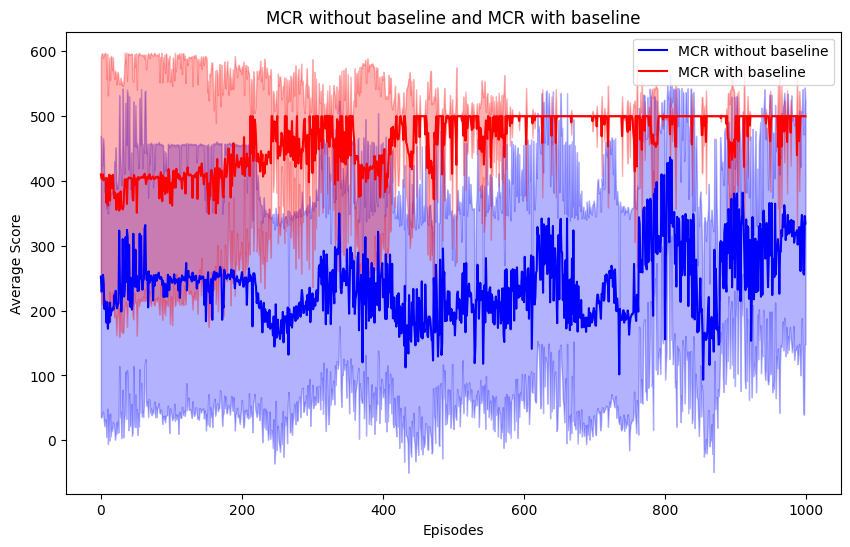

True

In [10]:
final_plot(tot_rewards_cwob,tot_rewards_cwb)

### Acrobot:

#### Wihtout baseline

In [12]:
import sys
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

env = gym.make('Acrobot-v1')
agent = MCREINFORCE(env)
gamma = 0.99
num_episodes= 1000
num_steps = 500
tot_rewards_awob = []
num_epochs = 5
env.seed(0)

for epoch in range(num_epochs):
    rewards = []
    for episode in range(num_episodes):
        state = env.reset()
        log_ps = []
        episode_rewards = []
        states = []
        for t in range(num_steps):
            action, log_p = agent.action_select(state)
            next_state, reward, done, _ = env.step(action)
            log_ps.append(log_p)
            episode_rewards.append(reward)
            states.append(state)
            state = next_state

            if done:
                break
        
        baseline_vals = None
        if agent.baseline:
            agent.update_baseline(episode_rewards,states)

            with torch.no_grad():
                state_tensor = torch.tensor(states).float()
                baseline_vals = agent.value_net(state_tensor).squeeze().tolist()

        R, pg = agent.calc_return_pg(log_ps, episode_rewards, gamma, baseline_vals)
        agent.update_policy(pg)
        rewards.append(np.array(episode_rewards).sum())
    tot_rewards_awob.append(rewards)

#### With baseline

In [18]:
import sys
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

env = gym.make('Acrobot-v1')
gamma = 0.99
num_episodes= 1000
num_steps = 500
tot_rewards_awb = []
num_epochs = 5
env.seed(0)

for seed in [13,14,15,16,17,18,19,20,21,22,23,24,25]:
    rewards = []
    agent = MCREINFORCE(env, seed=seed, baseline=True)

    for episode in range(num_episodes):
        state = env.reset()
        log_ps = []
        episode_rewards = []
        states = []
        for t in range(num_steps):
            action, log_p = agent.action_select(state)
            next_state, reward, done, _ = env.step(action)
            log_ps.append(log_p)
            episode_rewards.append(reward)
            states.append(state)
            state = next_state

            if done:
                break
        
        baseline_vals = None
        if agent.baseline:
            agent.update_baseline(episode_rewards,states)

            with torch.no_grad():
                state_tensor = torch.tensor(states).float()
                baseline_vals = agent.value_net(state_tensor).squeeze().tolist()

        R, pg = agent.calc_return_pg(log_ps, episode_rewards, gamma, baseline_vals)
        agent.update_policy(pg)
        rewards.append(np.array(episode_rewards).sum())
    tot_rewards_awb.append(rewards)

/home/user/miniconda3/envs/RL/lib/python3.12/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/user/miniconda3/envs/RL/lib/python3.12/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/user/miniconda3/envs/RL/lib/python3.12/site-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
/home/user/miniconda3/envs/RL/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning

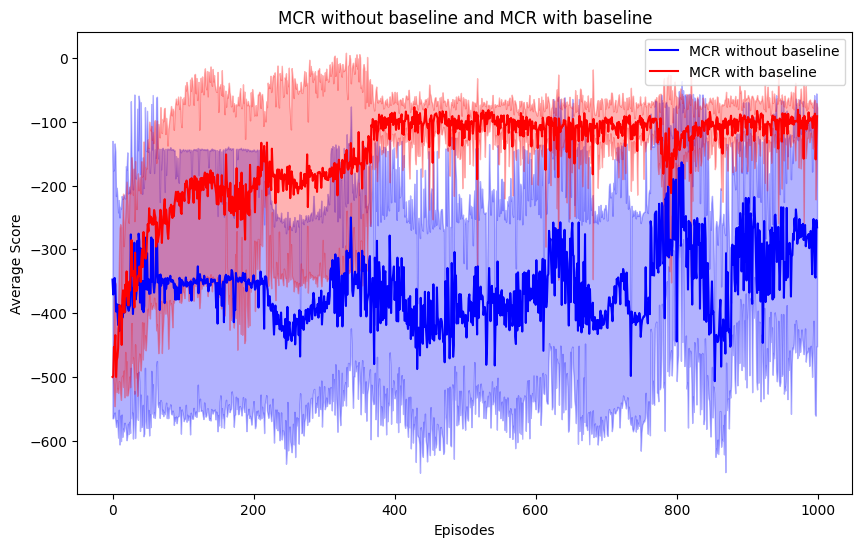

True

In [39]:
final_plot(tot_rewards_awob,tot_rewards_awb)